In [1]:
# !pip install opencv-python

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import pickle as pkl

In [2]:
import cv2
import os,pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## Import data for training 
img1 = cv2.imread('/home/spoudel/PR_assignments/assignment_2/Training_1.ppm')
ref1 = cv2.imread('/home/spoudel/PR_assignments/assignment_2/ref1.ppm')
img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
ref1_rgb = cv2.cvtColor(ref1, cv2.COLOR_BGR2RGB)

x,y,z = ref1_rgb.shape
training_data=[]
data_points = []
all_data=[]
for i in range(x):
    for j in range(y):
        r,g,b = img_rgb[i][j]
        r_f,g_f,b_f = float(r),float(g),float(b)

        r1 = r_f/(r_f+g_f+b_f+0.00000001)
        g1 = g_f/(r_f+g_f+b_f+0.00000001)
        
        all_data.append([r1,g1])
        if ref1_rgb[i][j].all() != 0:
            
            training_data.append([r1,g1])
            data_points.append([i,j])
            
            
#Calculate Priors
prior_skin=len(training_data)/(x*y)
prior_skin

0.06714554226119698

In [4]:
#Utility functions and Classes

def calculate_cov(X):
    X=np.array(X)
    N, M = X.shape
    # Calculate the covariance matrix
    cov = np.zeros((M, M))
    for i in range(M):
        # Mean of column "i"
        mean_i = np.sum(X[:, i]) / N
        for j in range(M):
            # Mean of column "j"
            mean_j = np.sum(X[:, j]) / N
            # Covariance between column "i" and column "j"
            cov[i, j] = np.sum((X[:, i] - mean_i) * (X[:, j] - mean_j)) / N
    return cov

def max_likelihood(X):
    mean=np.mean(X,axis=0)
#     conv=np.cov(X,rowvar=False)
    cov=calculate_cov(X)
    return mean,cov


class discriminant():
    def __init__ (self,mu,sigma,prior):
        self.mu=mu
        self.sigma=sigma
        self.prior=prior
        self.maxthreshold=1/(2*np.pi*(np.linalg.det(self.sigma))**(1/2))
        return None
    
    def predict(self,X,threshold=None):
        sigma_inv=np.linalg.inv(self.sigma)
        op_data= [1/((2*np.pi)**(2/2)*(np.linalg.det(self.sigma))**(1/2))* np.exp(-1/2*np.matmul((x-self.mu).T,np.matmul(sigma_inv,(x-self.mu)))) for x in X]
        print(max(op_data))
        if threshold!=None:
            return [0 if x>threshold else 1 for x in op_data]
        else:
            thresholds=np.linspace(0,self.maxthreshold,20,endpoint=True)
            to_ret=[[0 if x>threshold else 1 for x in op_data] for threshold in thresholds]
            return np.array(to_ret),thresholds
    


def misclf_rate(y_true, y_pred):
    y_true=list(y_true)
    y_pred=list(y_pred)
    total_class1 = y_true.count(0)
    total_class2 = y_true.count(1)
    misclf_class1 = 0
    misclf_class2 = 0    
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()    
    total_misclassification_rate = (fp+fn)/(tn+fp+fn+tp)   
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            if y_true[i] == 0:
                misclf_class1 += 1
            elif y_true[i] == 1:
                misclf_class2 += 1   
            
    class1_misclf_rate = misclf_class1/total_class1
    class2_misclf_rate = misclf_class2/total_class2    
    return class1_misclf_rate,class2_misclf_rate,total_misclassification_rate


def fpr_fnr(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    fpr=fp/(fp+tn)
    fnr=fn/(tp+fn)
    return fpr,fnr

194.39576241543


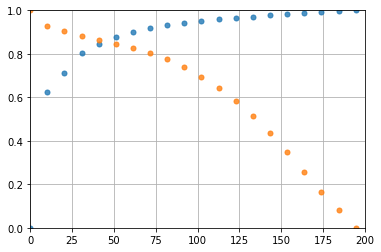

In [5]:
###Main function for training and seeing ROC for training data
X=np.array(training_data)
mean,sigma=max_likelihood(X)
discriminant_skin=discriminant(mu=mean,sigma=sigma,prior=prior_skin)
twenty_prediction_train,thresholds=discriminant_skin.predict(np.array(all_data))
#Generate y_true
y_mask=ref1_rgb[:,:,0].flatten()
y_true=[]
for i in y_mask:
    if i==0:
        y_true.append(0)
    else:
        y_true.append(1)
fpr,fnr=np.array([fpr_fnr(y_true,x) for x in twenty_prediction_train]).T
plt.plot(thresholds,fpr, '.', alpha=0.8, markersize=10)
plt.plot(thresholds,fnr, '.', alpha=0.8, markersize=10)
plt.xlim(0,200)
plt.ylim(0,1)
plt.grid()
plt.show()

In [6]:
# discriminant_skin.predict(X=np.array(all_data),threshold=0)

In [7]:
#Test1 image

def read_img_rg(img,ref):
    
    ## returns: all_data=rg_data
    ##          ref_data=mask_data
    
    img = cv2.imread(img)
    ref = cv2.imread(ref)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ref_rgb = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

    x,y,z = ref_rgb.shape
    print(x,y,z)
    training_data=[]
    data_points = []
    all_data=[]
    for i in range(x):
        for j in range(y):
            r,g,b = img_rgb[i][j]
            r_f,g_f,b_f = float(r),float(g),float(b)

            r1 = r_f/(r_f+g_f+b_f+0.00000001)
            g1 = g_f/(r_f+g_f+b_f+0.00000001)

            all_data.append([r1,g1])
            if ref_rgb[i][j].all() != 0:

                training_data.append([r1,g1])
                data_points.append([i,j])
    return img_rgb,np.array(all_data),np.array(ref_rgb)
                


In [8]:
#Read forst test image
test1_rgb,test1_img_rg,test1_ref=read_img_rg(img='/home/spoudel/PR_assignments/assignment_2/Training_3.ppm', 
                         ref='/home/spoudel/PR_assignments/assignment_2/ref3.ppm')

test1_rgb.shape,test1_img_rg.shape,test1_ref.shape

1392 1856 3


((1392, 1856, 3), (2583552, 2), (1392, 1856, 3))

194.4023441719109


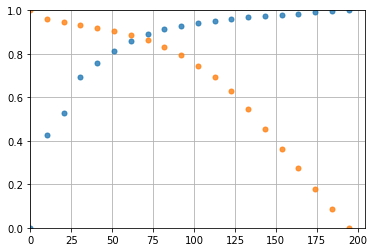

The point nearest to equal error rate among the twenty calculate threshold is threshold= 194.40662497904785  at index  6


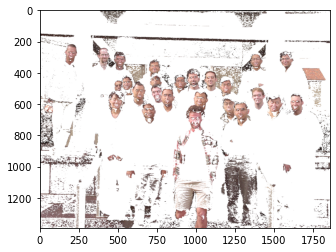

In [10]:
###Main function fpr training and seeing ROC for testing forst test images (Training_3.ppm)

def test_and_plot_roc(discriminant,img_rgb,rg_data,ref_rgb):
    twenty_prediction_train,thresholds=discriminant_skin.predict(np.array(rg_data))
    #Generate y_true
    y_mask=ref_rgb[:,:,0].flatten()
    y_true=[]
    for i in y_mask:
        if i==0:
            y_true.append(0)
        else:
            y_true.append(1)
            
            
    fpr,fnr=np.array([fpr_fnr(y_true,x) for x in twenty_prediction_train]).T
    plt.plot(thresholds,fpr, '.', alpha=0.8, markersize=10)
    plt.plot(thresholds,fnr, '.', alpha=0.8, markersize=10)
    plt.xlim(0,max(thresholds)+10)
    plt.ylim(0,1)
    plt.grid()
    plt.show()
    
    fpr_mn_fnr=3
    sav_index=0
    for index,fpr1 in enumerate(fpr):
        if fpr1-fnr[index]<abs(fpr_mn_fnr):
            fpr_mn_fnr=abs(fpr1-fnr[index])
            sav_index=index
    print("The point nearest to equal error rate among the twenty calculate threshold is threshold=",thresholds[index]," at index ", sav_index)
    
    plt.imshow(twenty_prediction_train[sav_index].reshape(x,y))
    
    img_rgb_cp=img_rgb.copy()
    mask=twenty_prediction_train[sav_index].reshape(x,y)
    for i in range(x):
        for j in range(y):
            if mask[i][j]!=0:
                img_rgb_cp[i][j]=[255,255,255]
    plt.imshow(img_rgb_cp)
    
    

test_and_plot_roc(discriminant=discriminant_skin,img_rgb=test1_rgb,rg_data=test1_img_rg,ref_rgb=test1_ref)

1392 1856 3
194.39576241543


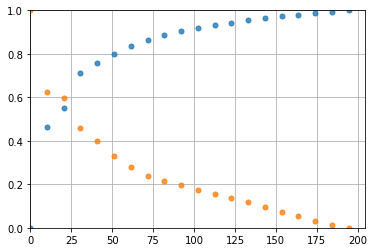

In [13]:
# test2_img_rg,test2_ref=read_img_rg(img='/home/spoudel/PR_assignments/assignment_2/Training_6.ppm', 
#                          ref='/home/spoudel/PR_assignments/assignment_2/ref6.ppm')

# test2_img_rg.shape,test2_ref.shape

# test_and_plot_roc(discriminant=discriminant_skin,rg_data=test2_img_rg,ref_rgb=test2_ref)

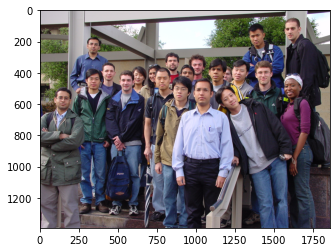

In [20]:
plt.imshow(img_rgb)

In [23]:
img_rgb[:,:,0]

array([[ 90,  91,  91, ...,  51,  53,  52],
       [ 95,  95,  96, ...,  47,  50,  51],
       [ 96,  95,  92, ...,  47,  47,  47],
       ...,
       [104, 107, 117, ...,  48,  53,  57],
       [112, 112, 117, ...,  51,  53,  52],
       [110, 113, 115, ...,  54,  58,  60]], dtype=uint8)

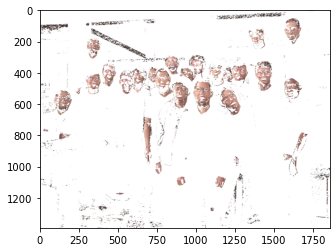

In [27]:
img_rgb_cp=img_rgb.copy()
mask=twenty_prediction_train[12].reshape(x,y)
for i in range(x):
    for j in range(y):
        if mask[i][j]!=0:
            img_rgb_cp[i][j]=[255,255,255]
plt.imshow(img_rgb_cp)

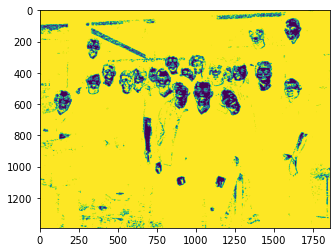

In [16]:
plt.imshow(twenty_prediction_train[12].reshape(x,y))